<a href="https://colab.research.google.com/github/chengzh2008/tensorflow-tutorials/blob/main/overfit_underfit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers
print(tf.__version__)

2.4.0


In [2]:
!pip install -q git+http://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

     |████████████████████████████████| 1.0MB 4.4MB/s 


In [3]:
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import pathlib
import shutil
import tempfile

In [4]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [5]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

2816409600/2816407858 [==============================] - 60s 0us/step


In [6]:
FEATURES = 28
ds = tf.data.experimental.CsvDataset(gz, [float(), ]*(FEATURES + 1), compression_type="GZIP")


In [7]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:], 1)
  return features, label


In [8]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


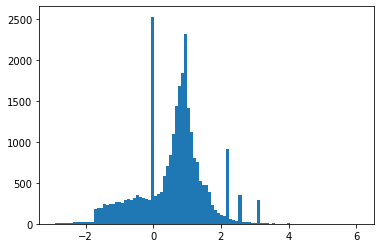

In [9]:
for features, label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins=101)

In [10]:
N_VALIDATION = int(1000)
N_TRAIN = int(10000)
BUFFER_SIZE = int(10000)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN // BATCH_SIZE

In [11]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [12]:
train_ds

<CacheDataset shapes: ((28,), ()), types: (tf.float32, tf.float32)>

In [13]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)


In [24]:
learning_rate_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*1000,
    decay_rate=1,
    staircase=False
)
def get_optimizer():
  return tf.keras.optimizers.Adam(learning_rate_schedule)

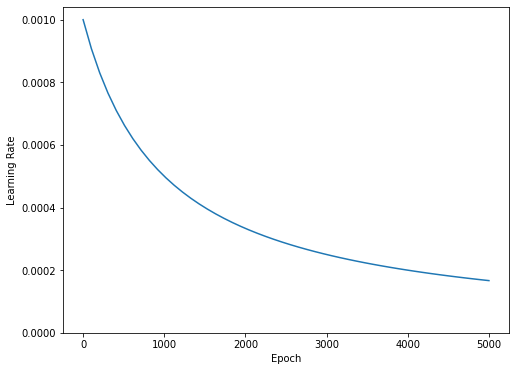

In [25]:
step = np.linspace(0, 100000)
lr = learning_rate_schedule(step)
plt.figure(figsize=(8, 6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [26]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

In [29]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                         tf.keras.losses.BinaryCrossentropy(from_logits=True, name='binary_crossentropy'),
                         'accuracy'
                ])
  model.summary()

  history = model.fit(
      train_ds,
      steps_per_epoch = STEPS_PER_EPOCH,
      epochs=max_epochs,
      validation_data=validate_ds,
      callbacks=get_callbacks(name),
      verbose=0)
  return history


In [34]:
# Tiny model
tiny_model = tf.keras.Sequential([ 
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

size_histories = {}

size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 16)                464       
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 17        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5035,  binary_crossentropy:0.7512,  loss:0.7512,  val_accuracy:0.4930,  val_binary_crossentropy:0.7191,  val_loss:0.7191,  
....................................................................................................
Epoch: 100, accuracy:0.6107,  binary_crossentropy:0.6226,  loss:0.6226,  val_accuracy:0.5830,  val_binary_crossentropy:0.6233,  val_loss:0.6233,  
....................................................................................................
Epoch: 200, accuracy:0.

(0.5, 0.7)

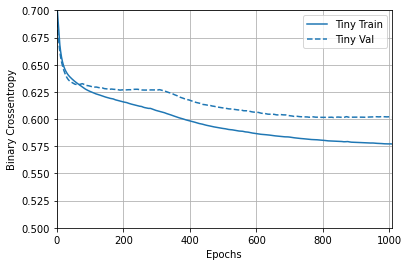

In [31]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

In [32]:
# small model
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

In [33]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 16)                464       
_________________________________________________________________
dense_9 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 17        
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4999,  binary_crossentropy:0.7165,  loss:0.7165,  val_accuracy:0.4820,  val_binary_crossentropy:0.7093,  val_loss:0.7093,  
....................................................................................................
Epoch: 100, accuracy:0.6217,  binary_crossentropy:0.6138,  loss:0.6138,  val_accuracy:0.6250,  val_binary_crossentropy:0.6206,  val_loss:0.